<a href="https://colab.research.google.com/github/Alexandre77777/data_mining/blob/main/3.%20Random%20Forest/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%965_Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №5. Random forest**

# Задание 1. Обучите классификатор Random Forest для решения задачи бинарной классификации: для каждого человека научиться предсказывать, выживет ли он при крушении Титаника.

Ссылка на датасет: https://www.kaggle.com/c/titanic/data

## 1. Устанавливаем зависимости

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import os

## 2. Импортируем датасет

In [10]:
df = pd.read_csv('titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Производим разведовательный анализ данных


Получим представление о данных в датасете:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 4. Сформируем обучающую и тестовую выборки:


In [37]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

In [13]:
from sklearn.model_selection import train_test_split

X = df.drop(['Survived', 'Name'], axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((596, 10), (596,), (295, 10), (295,))

## 5. Feature Engineering

Поработаем с признаками, выделим важные, изменим форму их представления (при надобности)

In [14]:
X_train.dtypes

,0
PassengerId,int64
Pclass,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64
Cabin,object
Embarked,object


In [15]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.7 MB/s eta 0:00:00


In [16]:
import category_encoders as ce

In [17]:
encoder = ce.OrdinalEncoder(cols=['Sex', 'Ticket', 'Cabin', 'Embarked'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

In [18]:
X_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
6,7,1,1,54.000000,0,0,1,51.8625,1,1
718,719,3,1,29.699118,0,0,2,15.5000,105,2
685,686,2,1,25.000000,1,2,3,41.5792,105,3
73,74,3,1,26.000000,1,0,4,14.4542,105,3
882,883,3,2,22.000000,0,0,5,10.5167,105,1


In [19]:
X_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,3,1,29.699118,1,1,-1.0,15.2458,105.0,3
439,440,2,1,31.000000,0,0,-1.0,10.5000,105.0,1
840,841,3,1,20.000000,0,0,-1.0,7.9250,105.0,1
720,721,2,2,6.000000,0,1,234.0,33.0000,105.0,1
39,40,3,2,14.000000,1,0,147.0,11.2417,105.0,3


## 6. Построение базовой модели:

In [20]:
rfc = RandomForestClassifier(n_estimators=10, random_state=1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

## 7. Оценка точности модели:

### 7.1. Напишите функцию, принимающую на вход аргументы y_pred, y_test и выполняющую визуализацию матрицы ошибок и отчета классификации

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

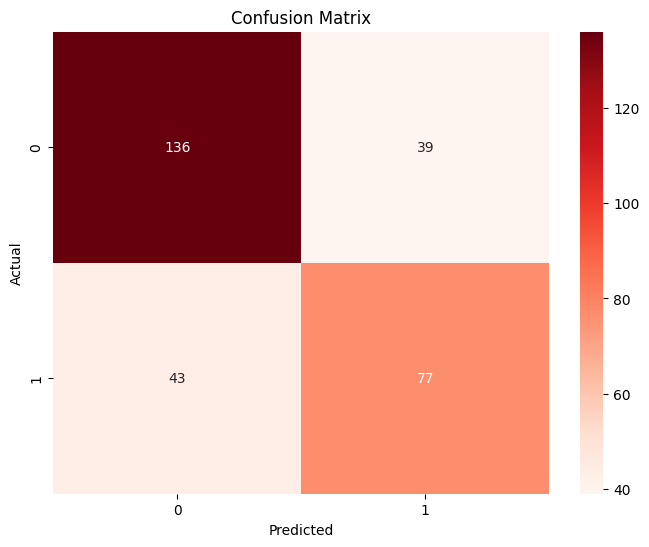

In [22]:
def rfc_m (y_test, y_pred_1):
    cm_1 = confusion_matrix(y_test, y_pred_1)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_1, annot=True, fmt=".0f", cmap='Reds')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

y_pred_1 = rfc.predict(X_test)
rfc_m (y_test, y_pred_1)

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       175
           1       0.66      0.64      0.65       120

    accuracy                           0.72       295
   macro avg       0.71      0.71      0.71       295
weighted avg       0.72      0.72      0.72       295



### 7.2. Оцените точность модели:

In [24]:
from sklearn.metrics import accuracy_score

print('Оценка точности модели при использовании 10 деревьев решений : {0:0.4f}'. format(accuracy_score(y_test, y_pred_1)))

Оценка точности модели при использовании 10 деревьев решений : 0.7220


## 8. Тюнинг гиперпараметров модели:

RandomSearchCV

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Определяем список значений для параметра n_estimators (количество деревьев в лесу)
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]

# Определяем список значений для параметра max_depth (максимальная глубина дерева)
max_depth = [int(x) for x in np.linspace(3, 50, num=5)]
max_depth.append(None)  # Добавляем значение None для отсутствия ограничения глубины

# Определяем список значений для параметра max_leaf_nodes (максимальное количество листовых узлов)
max_leaf_nodes = [int(i) for i in range(2, 100)]

# Определяем пространство гиперпараметров для случайного поиска
random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
}

# Создаем модель классификатора случайного леса с фиксированным random_state для воспроизводимости
rf_clf = RandomForestClassifier(random_state=1)

# Инициализируем RandomizedSearchCV для поиска оптимальных гиперпараметров
rf_cv = RandomizedSearchCV(
    estimator=rf_clf,                # модель для настройки
    param_distributions=random_grid, # словарь с параметрами для случайного поиска
    n_iter=100,                      # количество итераций (случайных наборов гиперпараметров)
    scoring='accuracy',              # метрика для оценки качества моделей
    cv=5,                            # количество фолдов для кросс-валидации
    verbose=1,                       # уровень детализации вывода
    random_state=42,                 # фиксированный сид для воспроизводимости результатов
    n_jobs=-1                        # использование всех доступных ядер процессора
)

# Обучаем модель RandomizedSearchCV на обучающих данных с перебором гиперпараметров
rf_cv.fit(X_train, y_train)

# Получаем оптимальные гиперпараметры после поиска
rf_best_params = rf_cv.best_params_
print(f"Лучшие параметры: {rf_best_params}")

# Создаем новый классификатор случайного леса с оптимальными гиперпараметрами
rf_clf = RandomForestClassifier(**rf_best_params)

# Обучаем модель с оптимальными гиперпараметрами на обучающих данных
rf_clf.fit(X_train, y_train)

# Предсказываем классы для тестовых данных
y_pred_2 = rf_clf.predict(X_test)

# Оцениваем точность модели на тестовых данных
print('Оценка точности модели при подборе параметров с помощью RandomizedSearchCV: {0:0.4f}'.format(accuracy_score(y_test, y_pred_2)))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Лучшие параметры: {'n_estimators': 30, 'max_leaf_nodes': 72, 'max_depth': 26}
Оценка точности модели при подборе параметров с помощью RandomizedSearchCV: 0.7831


GridSearchCV

In [36]:
from sklearn.model_selection import GridSearchCV

# Определяем список значений для параметра n_estimators (количество деревьев)
n_estimators = [int(i) for i in range(1, 15)]

# Определяем список значений для параметра max_depth (максимальная глубина дерева)
max_depth = [5, 10, 15]
max_depth.append(None)  # Добавляем значение None для отсутствия ограничения глубины

# Определяем список значений для параметра max_leaf_nodes (максимальное количество листьев)
max_leaf_nodes = [int(i) for i in range(2, 30)]

# Создаем словарь с параметрами для перебора в GridSearchCV
params_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
}

# Инициализируем классификатор случайного леса с фиксированным random_state для воспроизводимости
rf_clf = RandomForestClassifier(random_state=0)

# Настраиваем GridSearchCV для поиска наилучших гиперпараметров
rf_cv = GridSearchCV(
    estimator=rf_clf,        # модель для настройки
    param_grid=params_grid,  # словарь с параметрами для перебора
    scoring="accuracy",      # метрика для оценки качества моделей
    cv=5,                    # количество фолдов для кросс-валидации
    verbose=1,               # уровень детализации вывода
    n_jobs=-1                # использование всех доступных ядер процессора
)

# Обучаем модель GridSearchCV на обучающих данных
rf_cv.fit(X_train, y_train)

# Получаем лучшие найденные параметры
best_params = rf_cv.best_params_
print(f"Лучшие параметры: {best_params}")

# Обучаем окончательную модель с лучшими параметрами на обучающих данных
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

# Предсказываем классы для тестовых данных
y_pred_3 = rf_clf.predict(X_test)

# Выводим оценку точности модели на тестовых данных
print('Оценка точности модели при подборе параметров с помощью GridSearchCV: {0:0.4f}'.format(accuracy_score(y_test, y_pred_2)))

Fitting 5 folds for each of 1568 candidates, totalling 7840 fits
Лучшие параметры: {'max_depth': 10, 'max_leaf_nodes': 23, 'n_estimators': 10}
Оценка точности модели при подборе параметров с помощью GridSearchCV: 0.7831


## 9. Оценка лучшей модели:

Оценка точности модели при подборе параметров с помощью RandomizedSearchCV: 0.7220
Оценка точности модели при подборе параметров с помощью GridSearchCV: 0.7831


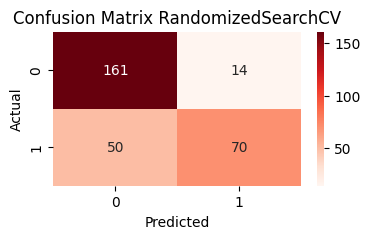

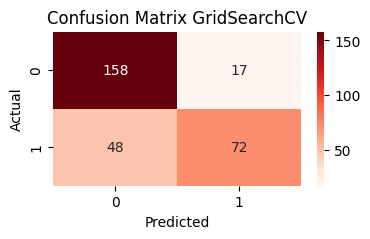

In [38]:
print('Оценка точности модели при подборе параметров с помощью RandomizedSearchCV: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print('Оценка точности модели при подборе параметров с помощью GridSearchCV: {0:0.4f}'.format(accuracy_score(y_test, y_pred_2)))

cm_2 = confusion_matrix(y_test, y_pred_2)

plt.figure(figsize=(4, 2))
sns.heatmap(cm_2, annot=True, fmt=".0f", cmap='Reds')
plt.title('Confusion Matrix RandomizedSearchCV')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

cm_3 = confusion_matrix(y_test, y_pred_3)

plt.figure(figsize=(4, 2))
sns.heatmap(cm_3, annot=True, fmt=".0f", cmap='Reds')
plt.title('Confusion Matrix GridSearchCV')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Задание 2. Решите задачу из предыдущего пункта используя другие, ранее пройденные классификаторы. Сравните их точность предсказания с Random Forest

In [39]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [40]:
tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [41]:
y_pred_tree = tree.predict(X_test)

In [42]:
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Точность дерева решений: {accuracy_tree:.4f}")

Точность дерева решений: 0.6610


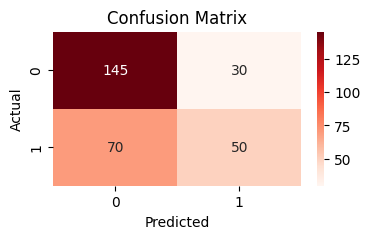

In [43]:
cm_4 = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(4, 2))
sns.heatmap(cm_4, annot=True, fmt=".0f", cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

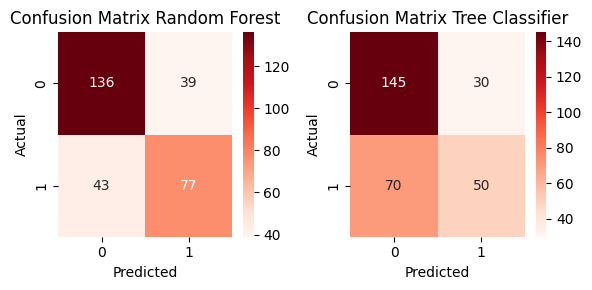

Точность леса решений : 0.7220
Точность дерева решений: 0.6610


In [44]:
def cm_all (y_test, y_pred_1, y_pred_tree):
    cm_1 = confusion_matrix(y_test, y_pred_1)
    cm_4 = confusion_matrix(y_test, y_pred_tree)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    sns.heatmap(cm_1, annot=True, fmt=".0f", cmap='Reds', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix Random Forest')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(cm_4, annot=True, fmt=".0f", cmap='Reds', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix Tree Classifier')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    plt.tight_layout()
    plt.show()

cm_all(y_test, y_pred_1, y_pred_tree)

print('Точность леса решений : {0:0.4f}'. format(accuracy_score(y_test, y_pred_1)))
print(f"Точность дерева решений: {accuracy_tree:.4f}")

# Задание 2.1*. Реализуйте функцию, для взаимодействия с обученной Вами моделью

* Функция должна принимать на вход обученную модель классификатора;

* После вызова функции, у пользователя через консоль запрашиваются значения признаков. При запросе значений нужно вывести пояснения о типе и диапазоне возможных значений. Также реализуйте обработку исключений;

* После ввода значений для всех признаков в консоль, выводится результат работы классификатора.

In [45]:
def interact_with_model(model):
    # Описание признаков и их возможных значений
    feature_descriptions = {
        'Pclass': 'Класс билета (1, 2, 3)',
        'Sex': 'Пол (male, female)',
        'Age': 'Возраст (число от 0 до 100)',
        'SibSp': 'Количество братьев/сестер или супругов на борту (число от 0 до 8)',
        'Parch': 'Количество родителей/детей на борту (число от 0 до 6)',
        'Fare': 'Плата за проезд (число от 0 до 512)',
        'Cabin': 'Номер каюты (строка, например, C85)',
        'Embarked': 'Порт посадки (C = Cherbourg, Q = Queenstown, S = Southampton)'
    }

    # Запрос значений признаков у пользователя
    input_data = {}
    for feature, description in feature_descriptions.items():
        while True:
            try:
                value = input(f"Введите значение для признака '{feature}' ({description}): ")
                if feature in ['Sex', 'Cabin', 'Embarked']:
                    input_data[feature] = value
                else:
                    input_data[feature] = float(value)
                break
            except ValueError:
                print("Ошибка: введено некорректное значение. Пожалуйста, попробуйте снова.")

    # Добавление недостающих столбцов с пустыми значениями
    for col in X_train.columns:
        if col not in input_data:
            input_data[col] = np.nan

    # Преобразование введенных данных в DataFrame
    input_df = pd.DataFrame([input_data])

    # Упорядочивание столбцов в соответствии с порядком столбцов в X_train
    input_df = input_df.reindex(columns=X_train.columns)

    # Преобразование категориальных признаков
    input_df = encoder.transform(input_df)

    # Предсказание результата
    prediction = model.predict(input_df)

    # Вывод результата
    if prediction[0] == 1:
        print("Предсказание: Выживший")
    else:
        print("Предсказание: Не выживший")

# Вызов функции для взаимодействия с моделью
interact_with_model(rf_clf)

Введите значение для признака 'Pclass' (Класс билета (1, 2, 3)): 1
Введите значение для признака 'Sex' (Пол (male, female)): male
Введите значение для признака 'Age' (Возраст (число от 0 до 100)): 25
Введите значение для признака 'SibSp' (Количество братьев/сестер или супругов на борту (число от 0 до 8)): 0
Введите значение для признака 'Parch' (Количество родителей/детей на борту (число от 0 до 6)): 0
Введите значение для признака 'Fare' (Плата за проезд (число от 0 до 512)): 250
Введите значение для признака 'Cabin' (Номер каюты (строка, например, C85)): C85
Введите значение для признака 'Embarked' (Порт посадки (C = Cherbourg, Q = Queenstown, S = Southampton)): C
Предсказание: Не выживший


# Задание 3. Решите задачу регрессии, используя [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

* Для выполнения данного задания можете использовать **любой датасет**



In [56]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [68]:
df = pd.read_csv('cars.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [70]:
df = df.drop('Car_Name', axis=1)
df = df.drop('Present_Price', axis=1)

In [71]:
df = pd.get_dummies(df, drop_first=True) #Преобразуем категориальные признаки

In [72]:
X = df.drop('Selling_Price', axis=1) #Разделим на признаки и целевую переменную
y = df['Selling_Price']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [75]:
y_pred = model.predict(X_test)

print("R2 score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 score: 0.8249655364195254
MSE: 4.032021179771687


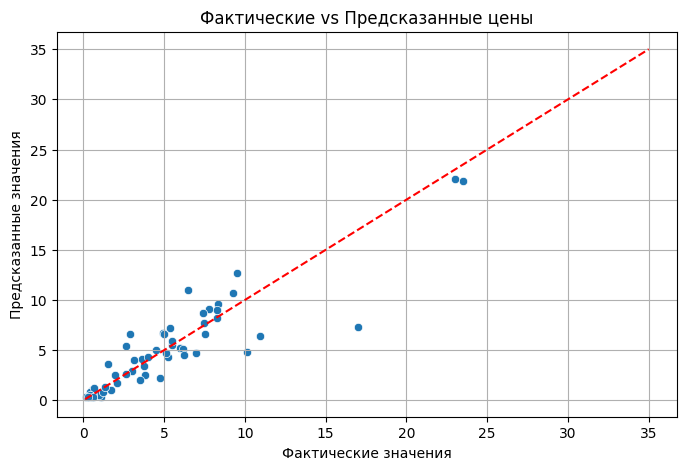

In [76]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # линия идеальных предсказаний
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические vs Предсказанные цены')
plt.grid(True)
plt.show()

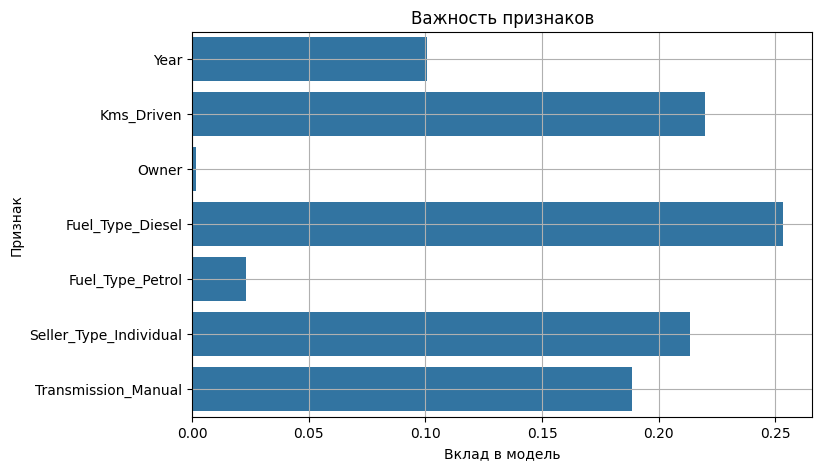

In [77]:
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title('Важность признаков')
plt.xlabel('Вклад в модель')
plt.ylabel('Признак')
plt.grid(True)
plt.show()